### implementing a GPT model from Scratch to Generate Text

In [2]:
from importlib.metadata import version

import matplotlib, tiktoken, torch

print("matplotlib ver:", version("matplotlib"), "tiktoken ver:", version("tiktoken"), "torch:", version("torch"))


matplotlib ver: 3.7.2 tiktoken ver: 0.6.0 torch: 2.1.2


- In this chapter, we implement a GPT-like LLM architecture; the next chapter will focus on training this LLM
- 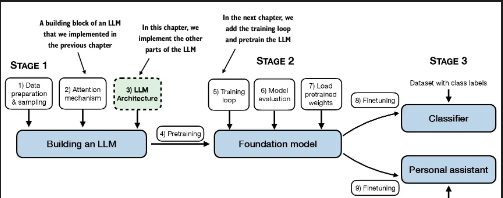

## ***Coding an LLM architecture***
- Compared to conventional deep learning models, LLms are larger, mainly due to their vast number of parameters, not the amount of code.
- 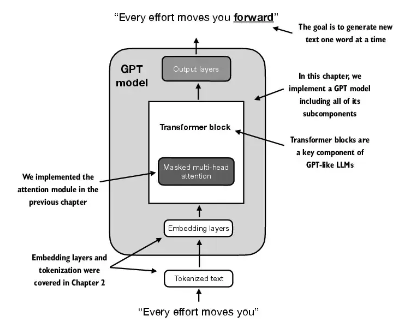
- In prev chapters, we used small embedding dimensions for token inputs and outputs for ease of illustration, ensuring they fit on a single page
- In this chapter, we consider embedding and model size akin to small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124m params). 
- Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762 and 1542 mill params

- Config details for the 124 million parameter GPT-2 model include:

In [4]:
GPT_CONFIG_124M = {
    "vocab_size"     : 50257,   # Supported by BPE tokenizer 
    "context_length" : 1024,    # Rep the models max input token count, as enabled by positional embeddings
    "emb_dim"        : 768,     # Embedding size for token inputs, converting each input token in 768-d vec
    "n_heads"        : 12,      # Number of attention heads in multi head attention
    "n_layers"       : 12,      # Number of transformer blocks within the model
    "drop_rate"      : 0.1,     # means dropping 10% of hidden units during training to mitigate overfitting
    "qkv_bias"       : False    # decides if the Linear layers in the multi-head should include a bias vector
}                                                                                       

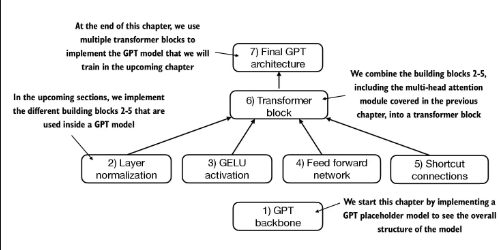

### 1) GPT backbone

In [5]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [ ]:
import torch
import torch.nn as nn 

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb  = nn.Embedding(cfg["vocab_size"], cfg['emb_dim'])
        self.pos_emb  = nn.Embedding(cfg["context_length"], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])


    # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

    # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(
            cfg["emb_dim"]
        )

        self.out_head   = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds  = self.tok_emb(in_idx)
        pos_embeds  = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x  = tok_embeds + pos_embeds
        x  = self.drop_emb(x)
        x  = self.trf_blocks(x)
        x  = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # this block does nothing and just returns its inputs
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface

    def forward(self, x):
        # This layer does nothing and just returns its input. 
        return x


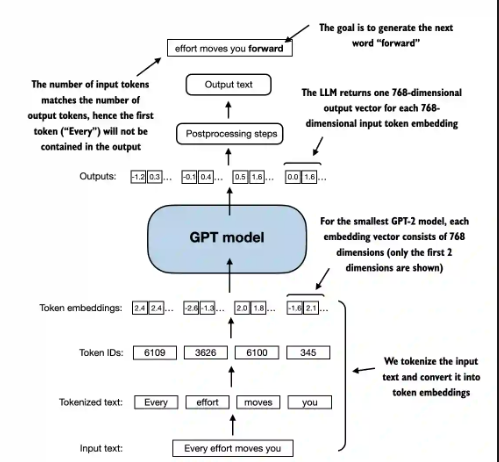